In [1]:
# Import modules
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import os
import optuna
import pickle
from sklearn.metrics import mean_absolute_error

In [2]:
# Read the CSV file
data_df =  pd.read_csv('robotex3.csv')
data_df.dtypes

start_time     object
start_lat     float64
start_lng     float64
end_lat       float64
end_lng       float64
ride_value    float64
dtype: object

Now we will explore the loaded data to identify outliers and other problems that might need fixing such as null values.

In [3]:
#Identify null values
print(data_df.isnull().sum())

start_time    0
start_lat     0
start_lng     0
end_lat       0
end_lng       0
ride_value    0
dtype: int64


In [4]:
#Look at the first rows
data_df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-03 14:45:20.160851000,59.434932,24.758606,59.427563,24.774151,0.29700
1,2022-03-03 15:40:07.383265000,59.424733,24.749469,59.441709,24.891627,2.02775
2,2022-03-04 11:59:02.598888000,59.423738,24.741646,59.466830,24.834828,1.76100
3,2022-03-02 16:04:51.240462000,59.496857,24.828910,59.414417,24.642077,3.45725
4,2022-03-06 14:52:31.126479000,59.396413,24.668565,59.444003,24.740095,1.65175


,start_lat,start_lng,end_lat,end_lng,ride_value
count,569034.000000,569034.000000,569034.000000,569034.000000,569034.000000
mean,59.428644,24.743525,59.398040,24.724387,2.240978
std,0.021771,0.056941,1.355901,1.570002,43.437704
min,59.321557,24.505199,-37.819979,-122.527651,0.115010
25%,59.418690,24.713291,59.415226,24.707732,0.544250
50%,59.432085,24.744750,59.430637,24.744284,1.057250
75%,59.439012,24.768208,59.439206,24.773858,1.709500
max,59.566998,24.973743,63.444884,144.966110,3172.298250


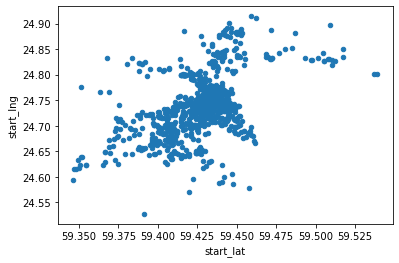

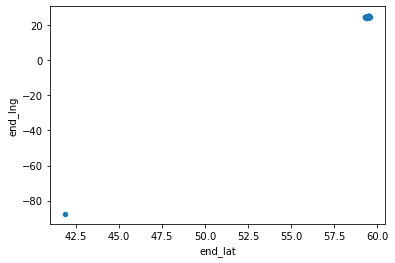

In [5]:
#Plot variables using only 1000 rows for efficiency
data_df.iloc[:1000].plot.scatter('start_lat', 'start_lng')
data_df.iloc[:1000].plot.scatter('end_lat', 'end_lng')

#Get distribution of values
data_df.describe()

Latitudes and longitudes have minus values that cannot be correct since Tallinn is at (59,24) aprox. We will remove points not near these coordinates.

![](Tallinn.png "Title")

In [6]:
#Clean dataset
def clean_df(df):
    return df[(df.start_lng >= 24) & (df.start_lng < 25) &
            (df.start_lat >= 59) & (df.start_lat < 60) &
            (df.end_lng >= 24) & (df.end_lng < 25) &
            (df.end_lat >= 59) & (df.end_lat < 60)]

data_df = clean_df(data_df)
print(len(data_df))

567016


,start_lat,start_lng,end_lat,end_lng,ride_value
count,567016.000000,567016.000000,567016.000000,567016.000000,567016.000000
mean,59.428651,24.743541,59.427083,24.743430,1.238974
std,0.021771,0.056950,0.026127,0.066015,0.906471
min,59.321557,24.505199,59.002879,24.050023,0.115010
25%,59.418709,24.713304,59.415306,24.707689,0.542500
50%,59.432088,24.744752,59.430630,24.744215,1.053000
75%,59.439016,24.768216,59.439166,24.773782,1.700250
max,59.566998,24.973743,59.567537,24.999321,16.681250


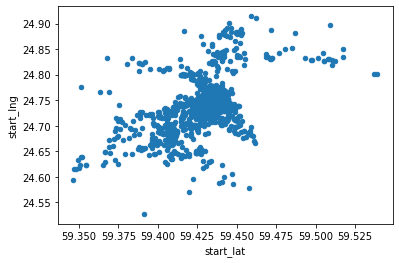

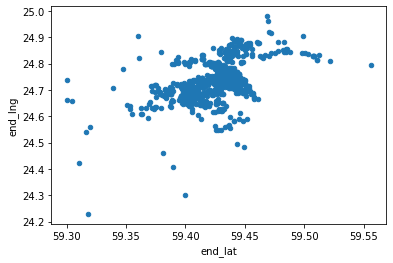

In [7]:
#Plot variables after cleaning
data_df.iloc[:1000].plot.scatter('start_lat', 'start_lng')
data_df.iloc[:1000].plot.scatter('end_lat', 'end_lng')

#Get distribution of values
data_df.describe()

Now that we have cleaned some extreme values, we will add some interesting features in the dataset.

- total_distance: distance from pickup to dropoff
- Extract useful information from datetime (day of week, month, hour, day)

In [8]:
def sphere_dist(start_lat, start_lng, end_lat, end_lng):
    """Gets pickup and dropoff lat and long and returns the distance between two points

    Args:
        start_lat (float): The pickup latitude
        start_lng (float): The pickup longitude
        end_lat (float): The dropout latitude
        end_lng (float): The dropout longitude

    Returns:
        float number: the distance
    """
    
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [start_lat, start_lng,
                                                              end_lat, end_lng])
    #Compute distances along lat, long dimensions
    dlat = end_lat - start_lat
    dlon = end_lng - start_lng
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(start_lat) * np.cos(end_lat) * np.sin(dlon/2.0)**2
    
    return 2 * R_earth * np.arcsin(np.sqrt(a))

def add_datetime_info(dataset):
    """Gets dataframe and extacts its month, day, hour and the week day

    Args:
        dataset (pandas dataframe): The data

    Returns:
        pandas dataframe: include month, day, hour and the week day columns
    """
    
    #Convert to datetime format
    dataset['start_time'] = pd.to_datetime(dataset['start_time'])
    
    dataset['hour'] = dataset.start_time.dt.hour
    dataset['day'] = dataset.start_time.dt.day
    dataset['month'] = dataset.start_time.dt.month
    dataset['weekday'] = dataset.start_time.dt.weekday
    
    return dataset


data_df['distance'] = sphere_dist(data_df['start_lat'], data_df['start_lng'], 
                                   data_df['end_lat'] , data_df['end_lng'])

data_df = add_datetime_info(data_df)

data_df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,distance,hour,day,month,weekday
0,2022-03-03 14:45:20.160851,59.434932,24.758606,59.427563,24.774151,0.29700,106.626777,14,3,3,3
1,2022-03-03 15:40:07.383265,59.424733,24.749469,59.441709,24.891627,2.02775,882.526278,15,3,3,3
2,2022-03-04 11:59:02.598888,59.423738,24.741646,59.466830,24.834828,1.76100,637.966336,11,4,3,4
3,2022-03-02 16:04:51.240462,59.496857,24.828910,59.414417,24.642077,3.45725,1270.837946,16,2,3,2
4,2022-03-06 14:52:31.126479,59.396413,24.668565,59.444003,24.740095,1.65175,533.645650,14,6,3,6


In [9]:
# Remove start_time column
data_df.drop(columns=['start_time'], inplace=True)
data_df.head()

,start_lat,start_lng,end_lat,end_lng,ride_value,distance,hour,day,month,weekday
0,59.434932,24.758606,59.427563,24.774151,0.29700,106.626777,14,3,3,3
1,59.424733,24.749469,59.441709,24.891627,2.02775,882.526278,15,3,3,3
2,59.423738,24.741646,59.466830,24.834828,1.76100,637.966336,11,4,3,4
3,59.496857,24.828910,59.414417,24.642077,3.45725,1270.837946,16,2,3,2
4,59.396413,24.668565,59.444003,24.740095,1.65175,533.645650,14,6,3,6


In [10]:
# Use a utility from sklearn to split our dataset to train and test datasets
train_df, test_df = train_test_split(data_df, test_size=0.1, random_state=42)
print('Number of the train data = ' + str(len(train_df)))
print('Number of the test data = ' + str(len(test_df)))

Number of the train data = 510314
Number of the test data = 56702


Add rotational latitudes and longitudes

In [11]:
#y' = y*cos(a) - x*sin(a)
#x' = y*sin(a) + x*cos(a)
train_df['start_long_15'] = train_df['start_lng']*np.cos(15* np.pi / 180) - train_df['start_lat']*np.sin(15* np.pi/180)
train_df['start_long_30'] = train_df['start_lng']*np.cos(30* np.pi / 180) - train_df['start_lat']*np.sin(30* np.pi/180)
train_df['start_long_45'] = train_df['start_lng']*np.cos(45* np.pi / 180) - train_df['start_lat']*np.sin(45* np.pi/180)
train_df['start_long_60'] = train_df['start_lng']*np.cos(60* np.pi / 180) - train_df['start_lat']*np.sin(60* np.pi/180)
train_df['start_long_75'] = train_df['start_lng']*np.cos(75* np.pi / 180) - train_df['start_lat']*np.sin(75* np.pi/180)

train_df['start_lat_15'] = train_df['start_lng']*np.sin(15* np.pi / 180) + train_df['start_lat']*np.cos(15* np.pi/180)
train_df['start_lat_30'] = train_df['start_lng']*np.sin(30* np.pi / 180) + train_df['start_lat']*np.cos(30* np.pi/180)
train_df['start_lat_45'] = train_df['start_lng']*np.sin(45* np.pi / 180) + train_df['start_lat']*np.cos(45* np.pi/180)
train_df['start_lat_60'] = train_df['start_lng']*np.sin(60* np.pi / 180) + train_df['start_lat']*np.cos(60* np.pi/180)
train_df['start_lat_75'] = train_df['start_lng']*np.sin(75* np.pi / 180) + train_df['start_lat']*np.cos(75* np.pi/180)

train_df['end_long_15'] = train_df['end_lng']*np.cos(15* np.pi / 180) - train_df['end_lat']*np.sin(15* np.pi/180)
train_df['end_long_30'] = train_df['end_lng']*np.cos(30* np.pi / 180) - train_df['end_lat']*np.sin(30* np.pi/180)
train_df['end_long_45'] = train_df['end_lng']*np.cos(45* np.pi / 180) - train_df['end_lat']*np.sin(45* np.pi/180)
train_df['end_long_60'] = train_df['end_lng']*np.cos(60* np.pi / 180) - train_df['end_lat']*np.sin(60* np.pi/180)
train_df['end_long_75'] = train_df['end_lng']*np.cos(75* np.pi / 180) - train_df['end_lat']*np.sin(75* np.pi/180)

train_df['end_lat_15'] = train_df['end_lng']*np.sin(15* np.pi / 180) + train_df['end_lat']*np.cos(15* np.pi/180)
train_df['end_lat_30'] = train_df['end_lng']*np.sin(30* np.pi / 180) + train_df['end_lat']*np.cos(30* np.pi/180)
train_df['end_lat_45'] = train_df['end_lng']*np.sin(45* np.pi / 180) + train_df['end_lat']*np.cos(45* np.pi/180)
train_df['end_lat_60'] = train_df['end_lng']*np.sin(60* np.pi / 180) + train_df['end_lat']*np.cos(60* np.pi/180)
train_df['end_lat_75'] = train_df['end_lng']*np.sin(75* np.pi / 180) + train_df['end_lat']*np.cos(75* np.pi/180)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [12]:
# Split the train dataset to train and validation parts
y = train_df['ride_value']
x = train_df.drop(columns=['ride_value'])

x_train,x_valid,y_train,y_valid = train_test_split(x,y,test_size=0.33, random_state=42)

To get better results from the prediction XGBoost model, we use Optuna library to find optimized hyper-parameters. Therefore we select the 50 percent of the train data and do the optimizing process.

In [13]:
_, x_opt, __, y_opt = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

In [14]:
# Objective function
def objective(trial):

    train_opt_x, test_opt_x, train_opt_y, test_opt_y = train_test_split(x_opt, y_opt, 
                      test_size = 0.33, random_state = 42)
    
    model = xgb.XGBRegressor(objective ='reg:squarederror', eval_metric ='rmse',
                             n_estimators=3000, tree_method='gpu_hist',
                             gamma=trial.suggest_loguniform("gamma", 0.3, 0.5),
                             min_child_weight=trial.suggest_int("min_child_weight", 0, 5),
                             max_depth=trial.suggest_int("max_depth", 10, 20),
                             learning_rate=trial.suggest_loguniform("learning_rate", 0.0005, 0.05),
                             subsample=trial.suggest_loguniform("subsample", 0.5,0.9),
                             colsample_bytree=trial.suggest_loguniform("colsample_bytree", 0.1, 0.5),
                             reg_alpha=trial.suggest_loguniform("reg_alpha", 0.8, 20))

    eval_set = [(test_opt_x, test_opt_y)]
    model.fit(train_opt_x, train_opt_y, early_stopping_rounds=5, eval_set=eval_set, verbose=False)

    rmse_ = model.best_score

    return rmse_

# Optimizing
study = optuna.create_study(direction="minimize")
study.optimize(objective,n_trials=40)

[I 2021-03-05 07:21:48,631] A new study created in memory with name: no-name-c15ca313-1025-4cb6-82bf-e463f47ebcc3
[I 2021-03-05 07:22:05,862] Trial 0 finished with value: 0.092854 and parameters: {'gamma': 0.30342465464108304, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.0032037418691695362, 'subsample': 0.6559303394727215, 'colsample_bytree': 0.1987808418062686, 'reg_alpha': 17.343298450207744}. Best is trial 0 with value: 0.092854.
[I 2021-03-05 07:22:41,206] Trial 1 finished with value: 0.08927 and parameters: {'gamma': 0.46543096289944097, 'min_child_weight': 5, 'max_depth': 20, 'learning_rate': 0.0018980584995193154, 'subsample': 0.6324806185017459, 'colsample_bytree': 0.38833302025453703, 'reg_alpha': 14.407014719224197}. Best is trial 1 with value: 0.08927.
[I 2021-03-05 07:22:45,518] Trial 2 finished with value: 0.079449 and parameters: {'gamma': 0.391194889940392, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.014110890941745374, 'subsample': 0.539094

[I 2021-03-05 07:31:49,075] Trial 24 finished with value: 0.089803 and parameters: {'gamma': 0.49532504926672494, 'min_child_weight': 5, 'max_depth': 18, 'learning_rate': 0.0012753913302246747, 'subsample': 0.8930482796335235, 'colsample_bytree': 0.23197629495329572, 'reg_alpha': 0.8295385166457577}. Best is trial 19 with value: 0.060486.
[I 2021-03-05 07:32:04,254] Trial 25 finished with value: 0.062838 and parameters: {'gamma': 0.4144206840054352, 'min_child_weight': 5, 'max_depth': 13, 'learning_rate': 0.005904485095306922, 'subsample': 0.843967512987087, 'colsample_bytree': 0.2962685579944285, 'reg_alpha': 1.6614745257181043}. Best is trial 19 with value: 0.060486.
[I 2021-03-05 07:32:34,027] Trial 26 finished with value: 0.059585 and parameters: {'gamma': 0.3459145238161467, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.0035647064359063175, 'subsample': 0.8652300866020953, 'colsample_bytree': 0.3574518987243339, 'reg_alpha': 1.0653764371004795}. Best is trial 26 with 

In [16]:
# The best hyper-parameters
best_param = study.best_params
best_param

{'gamma': 0.3179192005471219,
 'min_child_weight': 3,
 'max_depth': 19,
 'learning_rate': 0.0024643081138923085,
 'subsample': 0.7519933563011253,
 'colsample_bytree': 0.43659163132337225,
 'reg_alpha': 0.8099566902213448}

In [19]:
# Train the model on training data by means of gained optimized hyper-parameters
train_model = xgb.XGBRegressor(objective ='reg:squarederror', eval_metric ='rmse',
                         n_estimators=3000, tree_method='gpu_hist',
                         gamma = 0.31791920054712194,
                         min_child_weight = 3,
                         max_depth = 19,
                         learning_rate = 0.0024643081138923085,
                         subsample = 0.7519933563011253,
                         colsample_bytree = 0.43659163132337225,
                         reg_alpha = 0.8099566902213448)

eval_set = [(x_valid, y_valid)]
train_model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=eval_set)


[0]	validation_0-rmse:1.16814
[1]	validation_0-rmse:1.16531
[2]	validation_0-rmse:1.16249
[3]	validation_0-rmse:1.15970
[4]	validation_0-rmse:1.15692
[5]	validation_0-rmse:1.15414
[6]	validation_0-rmse:1.15137
[7]	validation_0-rmse:1.14861
[8]	validation_0-rmse:1.14586
[9]	validation_0-rmse:1.14309
[10]	validation_0-rmse:1.14035
[11]	validation_0-rmse:1.13761
[12]	validation_0-rmse:1.13488
[13]	validation_0-rmse:1.13214
[14]	validation_0-rmse:1.12942
[15]	validation_0-rmse:1.12669
[16]	validation_0-rmse:1.12396
[17]	validation_0-rmse:1.12124
[18]	validation_0-rmse:1.11855
[19]	validation_0-rmse:1.11583
[20]	validation_0-rmse:1.11316
[21]	validation_0-rmse:1.11049
[22]	validation_0-rmse:1.10779
[23]	validation_0-rmse:1.10511
[24]	validation_0-rmse:1.10245
[25]	validation_0-rmse:1.09979
[26]	validation_0-rmse:1.09716
[27]	validation_0-rmse:1.09453
[28]	validation_0-rmse:1.09190
[29]	validation_0-rmse:1.08929
[30]	validation_0-rmse:1.08668
[31]	validation_0-rmse:1.08408
[32]	validation_0-

[260]	validation_0-rmse:0.62621
[261]	validation_0-rmse:0.62473
[262]	validation_0-rmse:0.62324
[263]	validation_0-rmse:0.62174
[264]	validation_0-rmse:0.62028
[265]	validation_0-rmse:0.61881
[266]	validation_0-rmse:0.61734
[267]	validation_0-rmse:0.61588
[268]	validation_0-rmse:0.61441
[269]	validation_0-rmse:0.61294
[270]	validation_0-rmse:0.61148
[271]	validation_0-rmse:0.61002
[272]	validation_0-rmse:0.60857
[273]	validation_0-rmse:0.60711
[274]	validation_0-rmse:0.60568
[275]	validation_0-rmse:0.60423
[276]	validation_0-rmse:0.60279
[277]	validation_0-rmse:0.60138
[278]	validation_0-rmse:0.59993
[279]	validation_0-rmse:0.59849
[280]	validation_0-rmse:0.59708
[281]	validation_0-rmse:0.59567
[282]	validation_0-rmse:0.59426
[283]	validation_0-rmse:0.59284
[284]	validation_0-rmse:0.59144
[285]	validation_0-rmse:0.59004
[286]	validation_0-rmse:0.58865
[287]	validation_0-rmse:0.58724
[288]	validation_0-rmse:0.58585
[289]	validation_0-rmse:0.58445
[290]	validation_0-rmse:0.58306
[291]	va

[517]	validation_0-rmse:0.34206
[518]	validation_0-rmse:0.34126
[519]	validation_0-rmse:0.34049
[520]	validation_0-rmse:0.33969
[521]	validation_0-rmse:0.33891
[522]	validation_0-rmse:0.33812
[523]	validation_0-rmse:0.33734
[524]	validation_0-rmse:0.33656
[525]	validation_0-rmse:0.33577
[526]	validation_0-rmse:0.33500
[527]	validation_0-rmse:0.33424
[528]	validation_0-rmse:0.33348
[529]	validation_0-rmse:0.33270
[530]	validation_0-rmse:0.33194
[531]	validation_0-rmse:0.33117
[532]	validation_0-rmse:0.33040
[533]	validation_0-rmse:0.32963
[534]	validation_0-rmse:0.32886
[535]	validation_0-rmse:0.32811
[536]	validation_0-rmse:0.32736
[537]	validation_0-rmse:0.32660
[538]	validation_0-rmse:0.32586
[539]	validation_0-rmse:0.32509
[540]	validation_0-rmse:0.32433
[541]	validation_0-rmse:0.32359
[542]	validation_0-rmse:0.32285
[543]	validation_0-rmse:0.32211
[544]	validation_0-rmse:0.32137
[545]	validation_0-rmse:0.32063
[546]	validation_0-rmse:0.31991
[547]	validation_0-rmse:0.31918
[548]	va

[774]	validation_0-rmse:0.19169
[775]	validation_0-rmse:0.19127
[776]	validation_0-rmse:0.19084
[777]	validation_0-rmse:0.19043
[778]	validation_0-rmse:0.19002
[779]	validation_0-rmse:0.18961
[780]	validation_0-rmse:0.18920
[781]	validation_0-rmse:0.18879
[782]	validation_0-rmse:0.18839
[783]	validation_0-rmse:0.18798
[784]	validation_0-rmse:0.18757
[785]	validation_0-rmse:0.18717
[786]	validation_0-rmse:0.18676
[787]	validation_0-rmse:0.18637
[788]	validation_0-rmse:0.18596
[789]	validation_0-rmse:0.18556
[790]	validation_0-rmse:0.18516
[791]	validation_0-rmse:0.18476
[792]	validation_0-rmse:0.18435
[793]	validation_0-rmse:0.18395
[794]	validation_0-rmse:0.18355
[795]	validation_0-rmse:0.18316
[796]	validation_0-rmse:0.18277
[797]	validation_0-rmse:0.18237
[798]	validation_0-rmse:0.18198
[799]	validation_0-rmse:0.18159
[800]	validation_0-rmse:0.18119
[801]	validation_0-rmse:0.18080
[802]	validation_0-rmse:0.18041
[803]	validation_0-rmse:0.18001
[804]	validation_0-rmse:0.17963
[805]	va

[1030]	validation_0-rmse:0.11328
[1031]	validation_0-rmse:0.11307
[1032]	validation_0-rmse:0.11285
[1033]	validation_0-rmse:0.11263
[1034]	validation_0-rmse:0.11242
[1035]	validation_0-rmse:0.11220
[1036]	validation_0-rmse:0.11199
[1037]	validation_0-rmse:0.11177
[1038]	validation_0-rmse:0.11155
[1039]	validation_0-rmse:0.11134
[1040]	validation_0-rmse:0.11113
[1041]	validation_0-rmse:0.11092
[1042]	validation_0-rmse:0.11071
[1043]	validation_0-rmse:0.11050
[1044]	validation_0-rmse:0.11029
[1045]	validation_0-rmse:0.11008
[1046]	validation_0-rmse:0.10987
[1047]	validation_0-rmse:0.10966
[1048]	validation_0-rmse:0.10945
[1049]	validation_0-rmse:0.10925
[1050]	validation_0-rmse:0.10904
[1051]	validation_0-rmse:0.10884
[1052]	validation_0-rmse:0.10864
[1053]	validation_0-rmse:0.10844
[1054]	validation_0-rmse:0.10824
[1055]	validation_0-rmse:0.10803
[1056]	validation_0-rmse:0.10783
[1057]	validation_0-rmse:0.10763
[1058]	validation_0-rmse:0.10742
[1059]	validation_0-rmse:0.10723
[1060]	val

[1279]	validation_0-rmse:0.07397
[1280]	validation_0-rmse:0.07386
[1281]	validation_0-rmse:0.07375
[1282]	validation_0-rmse:0.07365
[1283]	validation_0-rmse:0.07354
[1284]	validation_0-rmse:0.07344
[1285]	validation_0-rmse:0.07333
[1286]	validation_0-rmse:0.07323
[1287]	validation_0-rmse:0.07312
[1288]	validation_0-rmse:0.07301
[1289]	validation_0-rmse:0.07291
[1290]	validation_0-rmse:0.07280
[1291]	validation_0-rmse:0.07270
[1292]	validation_0-rmse:0.07259
[1293]	validation_0-rmse:0.07249
[1294]	validation_0-rmse:0.07238
[1295]	validation_0-rmse:0.07227
[1296]	validation_0-rmse:0.07216
[1297]	validation_0-rmse:0.07206
[1298]	validation_0-rmse:0.07196
[1299]	validation_0-rmse:0.07186
[1300]	validation_0-rmse:0.07176
[1301]	validation_0-rmse:0.07167
[1302]	validation_0-rmse:0.07157
[1303]	validation_0-rmse:0.07147
[1304]	validation_0-rmse:0.07136
[1305]	validation_0-rmse:0.07126
[1306]	validation_0-rmse:0.07116
[1307]	validation_0-rmse:0.07106
[1308]	validation_0-rmse:0.07096
[1309]	val

[1528]	validation_0-rmse:0.05444
[1529]	validation_0-rmse:0.05440
[1530]	validation_0-rmse:0.05434
[1531]	validation_0-rmse:0.05429
[1532]	validation_0-rmse:0.05424
[1533]	validation_0-rmse:0.05418
[1534]	validation_0-rmse:0.05413
[1535]	validation_0-rmse:0.05408
[1536]	validation_0-rmse:0.05402
[1537]	validation_0-rmse:0.05397
[1538]	validation_0-rmse:0.05392
[1539]	validation_0-rmse:0.05387
[1540]	validation_0-rmse:0.05382
[1541]	validation_0-rmse:0.05377
[1542]	validation_0-rmse:0.05371
[1543]	validation_0-rmse:0.05366
[1544]	validation_0-rmse:0.05361
[1545]	validation_0-rmse:0.05357
[1546]	validation_0-rmse:0.05352
[1547]	validation_0-rmse:0.05346
[1548]	validation_0-rmse:0.05341
[1549]	validation_0-rmse:0.05336
[1550]	validation_0-rmse:0.05330
[1551]	validation_0-rmse:0.05325
[1552]	validation_0-rmse:0.05321
[1553]	validation_0-rmse:0.05316
[1554]	validation_0-rmse:0.05311
[1555]	validation_0-rmse:0.05306
[1556]	validation_0-rmse:0.05300
[1557]	validation_0-rmse:0.05295
[1558]	val

[1777]	validation_0-rmse:0.04497
[1778]	validation_0-rmse:0.04494
[1779]	validation_0-rmse:0.04492
[1780]	validation_0-rmse:0.04489
[1781]	validation_0-rmse:0.04486
[1782]	validation_0-rmse:0.04483
[1783]	validation_0-rmse:0.04481
[1784]	validation_0-rmse:0.04478
[1785]	validation_0-rmse:0.04475
[1786]	validation_0-rmse:0.04473
[1787]	validation_0-rmse:0.04471
[1788]	validation_0-rmse:0.04468
[1789]	validation_0-rmse:0.04466
[1790]	validation_0-rmse:0.04464
[1791]	validation_0-rmse:0.04462
[1792]	validation_0-rmse:0.04460
[1793]	validation_0-rmse:0.04458
[1794]	validation_0-rmse:0.04456
[1795]	validation_0-rmse:0.04454
[1796]	validation_0-rmse:0.04451
[1797]	validation_0-rmse:0.04448
[1798]	validation_0-rmse:0.04446
[1799]	validation_0-rmse:0.04443
[1800]	validation_0-rmse:0.04441
[1801]	validation_0-rmse:0.04438
[1802]	validation_0-rmse:0.04436
[1803]	validation_0-rmse:0.04433
[1804]	validation_0-rmse:0.04430
[1805]	validation_0-rmse:0.04428
[1806]	validation_0-rmse:0.04426
[1807]	val

[2026]	validation_0-rmse:0.04039
[2027]	validation_0-rmse:0.04038
[2028]	validation_0-rmse:0.04036
[2029]	validation_0-rmse:0.04035
[2030]	validation_0-rmse:0.04033
[2031]	validation_0-rmse:0.04032
[2032]	validation_0-rmse:0.04031
[2033]	validation_0-rmse:0.04030
[2034]	validation_0-rmse:0.04029
[2035]	validation_0-rmse:0.04028
[2036]	validation_0-rmse:0.04026
[2037]	validation_0-rmse:0.04025
[2038]	validation_0-rmse:0.04024
[2039]	validation_0-rmse:0.04023
[2040]	validation_0-rmse:0.04021
[2041]	validation_0-rmse:0.04019
[2042]	validation_0-rmse:0.04018
[2043]	validation_0-rmse:0.04017
[2044]	validation_0-rmse:0.04015
[2045]	validation_0-rmse:0.04013
[2046]	validation_0-rmse:0.04012
[2047]	validation_0-rmse:0.04011
[2048]	validation_0-rmse:0.04010
[2049]	validation_0-rmse:0.04009
[2050]	validation_0-rmse:0.04008
[2051]	validation_0-rmse:0.04006
[2052]	validation_0-rmse:0.04005
[2053]	validation_0-rmse:0.04004
[2054]	validation_0-rmse:0.04003
[2055]	validation_0-rmse:0.04002
[2056]	val

[2275]	validation_0-rmse:0.03805
[2276]	validation_0-rmse:0.03804
[2277]	validation_0-rmse:0.03804
[2278]	validation_0-rmse:0.03803
[2279]	validation_0-rmse:0.03802
[2280]	validation_0-rmse:0.03801
[2281]	validation_0-rmse:0.03801
[2282]	validation_0-rmse:0.03800
[2283]	validation_0-rmse:0.03800
[2284]	validation_0-rmse:0.03799
[2285]	validation_0-rmse:0.03799
[2286]	validation_0-rmse:0.03798
[2287]	validation_0-rmse:0.03797
[2288]	validation_0-rmse:0.03797
[2289]	validation_0-rmse:0.03796
[2290]	validation_0-rmse:0.03795
[2291]	validation_0-rmse:0.03795
[2292]	validation_0-rmse:0.03794
[2293]	validation_0-rmse:0.03793
[2294]	validation_0-rmse:0.03793
[2295]	validation_0-rmse:0.03792
[2296]	validation_0-rmse:0.03791
[2297]	validation_0-rmse:0.03791
[2298]	validation_0-rmse:0.03791
[2299]	validation_0-rmse:0.03790
[2300]	validation_0-rmse:0.03790
[2301]	validation_0-rmse:0.03789
[2302]	validation_0-rmse:0.03789
[2303]	validation_0-rmse:0.03788
[2304]	validation_0-rmse:0.03788
[2305]	val

[2524]	validation_0-rmse:0.03680
[2525]	validation_0-rmse:0.03680
[2526]	validation_0-rmse:0.03680
[2527]	validation_0-rmse:0.03679
[2528]	validation_0-rmse:0.03679
[2529]	validation_0-rmse:0.03679
[2530]	validation_0-rmse:0.03678
[2531]	validation_0-rmse:0.03677
[2532]	validation_0-rmse:0.03677
[2533]	validation_0-rmse:0.03677
[2534]	validation_0-rmse:0.03676
[2535]	validation_0-rmse:0.03676
[2536]	validation_0-rmse:0.03676
[2537]	validation_0-rmse:0.03676
[2538]	validation_0-rmse:0.03675
[2539]	validation_0-rmse:0.03675
[2540]	validation_0-rmse:0.03675
[2541]	validation_0-rmse:0.03674
[2542]	validation_0-rmse:0.03674
[2543]	validation_0-rmse:0.03673
[2544]	validation_0-rmse:0.03673
[2545]	validation_0-rmse:0.03673
[2546]	validation_0-rmse:0.03672
[2547]	validation_0-rmse:0.03672
[2548]	validation_0-rmse:0.03671
[2549]	validation_0-rmse:0.03671
[2550]	validation_0-rmse:0.03671
[2551]	validation_0-rmse:0.03670
[2552]	validation_0-rmse:0.03670
[2553]	validation_0-rmse:0.03669
[2554]	val

[2773]	validation_0-rmse:0.03607
[2774]	validation_0-rmse:0.03607
[2775]	validation_0-rmse:0.03607
[2776]	validation_0-rmse:0.03606
[2777]	validation_0-rmse:0.03606
[2778]	validation_0-rmse:0.03606
[2779]	validation_0-rmse:0.03605
[2780]	validation_0-rmse:0.03605
[2781]	validation_0-rmse:0.03605
[2782]	validation_0-rmse:0.03605
[2783]	validation_0-rmse:0.03605
[2784]	validation_0-rmse:0.03605
[2785]	validation_0-rmse:0.03604
[2786]	validation_0-rmse:0.03604
[2787]	validation_0-rmse:0.03604
[2788]	validation_0-rmse:0.03604
[2789]	validation_0-rmse:0.03604
[2790]	validation_0-rmse:0.03603
[2791]	validation_0-rmse:0.03603
[2792]	validation_0-rmse:0.03603
[2793]	validation_0-rmse:0.03603
[2794]	validation_0-rmse:0.03603
[2795]	validation_0-rmse:0.03603
[2796]	validation_0-rmse:0.03602
[2797]	validation_0-rmse:0.03602
[2798]	validation_0-rmse:0.03602
[2799]	validation_0-rmse:0.03602
[2800]	validation_0-rmse:0.03601
[2801]	validation_0-rmse:0.03601
[2802]	validation_0-rmse:0.03601
[2803]	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.43659163132337225,
             eval_metric='rmse', gamma=0.3179192005471219, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.0024643081138923085, max_delta_step=0,
             max_depth=19, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=2,
             num_parallel_tree=1, random_state=0, reg_alpha=0.8099566902213448,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7519933563011253,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [ ]:
# Save the model
pickle.dump(train_model, open("./pred_model.dat", "wb"))

In [ ]:
# Load the model
#xgb_model_loaded = pickle.load(open("./pred_model.dat", "rb"))

In [20]:
# Prepare the test dataset, like the train dataset
#y' = y*cos(a) - x*sin(a)
#x' = y*sin(a) + x*cos(a)
test_df['start_long_15'] = test_df['start_lng']*np.cos(15* np.pi / 180) - test_df['start_lat']*np.sin(15* np.pi/180)
test_df['start_long_30'] = test_df['start_lng']*np.cos(30* np.pi / 180) - test_df['start_lat']*np.sin(30* np.pi/180)
test_df['start_long_45'] = test_df['start_lng']*np.cos(45* np.pi / 180) - test_df['start_lat']*np.sin(45* np.pi/180)
test_df['start_long_60'] = test_df['start_lng']*np.cos(60* np.pi / 180) - test_df['start_lat']*np.sin(60* np.pi/180)
test_df['start_long_75'] = test_df['start_lng']*np.cos(75* np.pi / 180) - test_df['start_lat']*np.sin(75* np.pi/180)

test_df['start_lat_15'] = test_df['start_lng']*np.sin(15* np.pi / 180) + test_df['start_lat']*np.cos(15* np.pi/180)
test_df['start_lat_30'] = test_df['start_lng']*np.sin(30* np.pi / 180) + test_df['start_lat']*np.cos(30* np.pi/180)
test_df['start_lat_45'] = test_df['start_lng']*np.sin(45* np.pi / 180) + test_df['start_lat']*np.cos(45* np.pi/180)
test_df['start_lat_60'] = test_df['start_lng']*np.sin(60* np.pi / 180) + test_df['start_lat']*np.cos(60* np.pi/180)
test_df['start_lat_75'] = test_df['start_lng']*np.sin(75* np.pi / 180) + test_df['start_lat']*np.cos(75* np.pi/180)

test_df['end_long_15'] = test_df['end_lng']*np.cos(15* np.pi / 180) - test_df['end_lat']*np.sin(15* np.pi/180)
test_df['end_long_30'] = test_df['end_lng']*np.cos(30* np.pi / 180) - test_df['end_lat']*np.sin(30* np.pi/180)
test_df['end_long_45'] = test_df['end_lng']*np.cos(45* np.pi / 180) - test_df['end_lat']*np.sin(45* np.pi/180)
test_df['end_long_60'] = test_df['end_lng']*np.cos(60* np.pi / 180) - test_df['end_lat']*np.sin(60* np.pi/180)
test_df['end_long_75'] = test_df['end_lng']*np.cos(75* np.pi / 180) - test_df['end_lat']*np.sin(75* np.pi/180)

test_df['end_lat_15'] = test_df['end_lng']*np.sin(15* np.pi / 180) + test_df['end_lat']*np.cos(15* np.pi/180)
test_df['end_lat_30'] = test_df['end_lng']*np.sin(30* np.pi / 180) + test_df['end_lat']*np.cos(30* np.pi/180)
test_df['end_lat_45'] = test_df['end_lng']*np.sin(45* np.pi / 180) + test_df['end_lat']*np.cos(45* np.pi/180)
test_df['end_lat_60'] = test_df['end_lng']*np.sin(60* np.pi / 180) + test_df['end_lat']*np.cos(60* np.pi/180)
test_df['end_lat_75'] = test_df['end_lng']*np.sin(75* np.pi / 180) + test_df['end_lat']*np.cos(75* np.pi/180)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [21]:
# Evaluation
y_true = test_df['ride_value']
x_pred = test_df.drop(columns=['ride_value'])

y_pred = train_model.predict(x_pred)

mean_absolute_error(y_true, y_pred)

0.019429514845392445

Tip:
- Adding data such as number of passengers, number of stops along the way, weather conditions, and how long the trip has took make the prediction more realistic.